# Understanding details about how Langosco et al.'s nets work
Let's understand lots of details about [the goal misgeneralization paper](). In particular, we'll be looking at the cheese-maze task from the goal misgeneralization task, for which cheese was spawned in the 5x5 top-right corner of the maze. 

Key conclusions:
1. Convolutional layers limit speed of information propagation (_locality_). More precisely, any portions of the state separated by `n` pixels take **??** convolutional layers to interact.
2. In the maximal maze size of **??**, there is at most two steps of computation involving information from e.g. opposite corners of the maze. 

In [189]:
# %% Don't have to restart kernel and reimport each time you modify a dependency
%reload_ext autoreload
%autoreload 2

# %%
# Imports
from typing import List, Tuple, Dict, Union, Optional, Callable
import re 

import numpy as np
import pandas as pd
import torch as t
import plotly.express as px
import plotly as py
import plotly.graph_objects as go
from tqdm import tqdm
from einops import rearrange
from IPython.display import Video, display, clear_output, IFrame
from ipywidgets import Text, interact, IntSlider, fixed, FloatSlider, Dropdown
import itertools
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import matplotlib.pyplot as plt

# NOTE: this is Monte's RL hooking code (and other stuff will be added in the future)
# Install normally with: pip install circrl
import circrl.module_hook as cmh
import procgen_tools.models as models
from experiments.patch_utils import *

# %% 
# Load two levels and get values
import pickle as pkl
from procgen import ProcgenGym3Env

rand_region = 5
# Check whether we're in jupyter
try:
    get_ipython()
    in_jupyter = True
except NameError:
    in_jupyter = False
path_prefix = '../' if in_jupyter else ''

# %%
# Load model

policy = models.load_policy(path_prefix + f'trained_models/maze_I/model_rand_region_{rand_region}.pth', 15, t.device('cpu'))

# %% Experiment parameters
label = 'embedder.block2.res1.resadd_out'
interesting_coeffs = np.linspace(-2/3,2/3,10) 
hook = cmh.ModuleHook(policy)

In [190]:
# Let's visualize the architecture itself
hook.probe_with_input(dummy_obs("R"))
labels = list(hook.values_by_label.keys())[:-1] # Skip the "_out" layer

import netron 

port = 6006
model_path = path_prefix + 'trained_models/maze_I/model_rand_region_5.pth'
netron.start(model_path, 6006, browse=False)
IFrame(f"http://localhost:{port}", width=1000, height=1000)
# Show PNG of the model from netron
netron.stop()

Stopping http://localhost:6006
Serving '../trained_models/maze_I/model_rand_region_5.pth' at http://localhost:6006


In [171]:
def dummy_obs(color: str, location: Tuple[int, int]=(32,32)):
    """ Return two mostly-black images, with the first containing a red/green/blue pixel in the center. Returns shape (2, 3, 64, 64). """
    
    assert color in ['R', 'G', 'B'], f'Color must be one of R, G, B, not {color}'
    assert len(location) == 2, 'Location must be a tuple of length 2'
    assert all(0 <= x < 64 for x in location), 'Location must be in [0, 64)'

    channel = {'R': 0, 'G': 1, 'B': 2}[color]
    dummy_obs = np.zeros((2, 3, 64, 64), dtype=np.float32)
    dummy_obs[0, channel, location[0], location[1]] = 1 # Have one pixel in the middle, in the given channel
    return dummy_obs

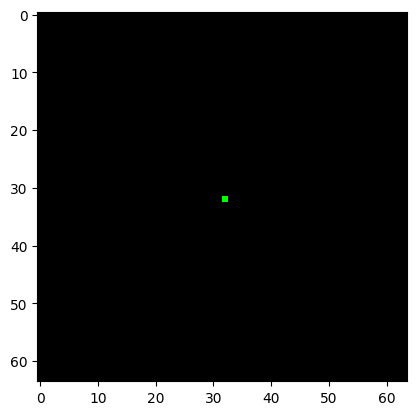

In [176]:
# Let's load a dummy observation with only one nonzero value
plt.imshow(dummy_obs("G")[0].transpose(1,2,0))

In [209]:
# Let's visualize the activations at each layer using plotly, using an interactive interface that lets us slide the R/G/B pixel around
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

def plot_activation_diffs(label: str, channel: int, obs: np.ndarray, fig: go.FigureWidget):
    """ Plot the activations of a given channel at a given layer, taking in an obs of shape (2,3,64,64). """
    # Get the activations
    assert obs.shape == (2,3,64,64), f"Obs must be of shape (2,3,64,64), not {obs.shape}"
    hook.probe_with_input(obs) # Run the model with the given obs
    activations = hook.get_value_by_label(label) # Shape is (b, c, h, w) at conv layers, (b, activations) at linear layers
    diff_activations = activations[0] - activations[1] # Subtract in order to cancel out bias terms which don't behave differently in the presence of our 1/0 discrepancy on the input

    # Ensure there's a fixed green/red colorscale, centered at white=0
    if len(activations.shape) == 2: # Linear layer
        # Unsqueeze the np.ndarray
        diff_activations = np.expand_dims(diff_activations, axis=(0,1))
        # If there's only a single channel, display a 1D Heatmap, with a single y value and the activation indices as the x values
        new_data = go.Heatmap(y=diff_activations[channel],  x=np.arange(diff_activations.shape[2]))
    else: 
        assert channel < activations.shape[1], "Channel doesn't exist at this layer"
        new_data = go.Heatmap(z=diff_activations[channel])

    # Update data
    fig.update(data=[go.Heatmap(z=diff_activations[channel])])

    # Set the min and max to be the min and max of all channels at this label
    bounds = np.abs(diff_activations).max()
    fig.update_traces(zmin=-1 * bounds, zmid=0, zmax=bounds)

    # Change the colorscale to split red (negative) -- white (zero) -- blue (positive)
    fig.update_traces(colorscale='RdBu')
    
    fig.update_layout(height=500, width=500, title_text=label)

channel_slider = IntSlider(min=0, max=127, step=1, value=0)
fig = go.FigureWidget()
display(fig)

@interact 
def plot_activations_interactive(label=Dropdown(options=labels), channel=channel_slider, dummy_color=Dropdown(options=["R","G","B"]), x=IntSlider(min=0, max=63, step=1, value=32), y=IntSlider(min=0, max=63, step=1, value=32)):
    # Set max channel to be the max channel at this layer
    shap = hook.get_value_by_label(label).shape
    channel_slider.max = shap[1] - 1 if len(shap) > 2 else 0
    channel = min(channel, channel_slider.max) # Catch inappropriate values
    plot_activation_diffs(label=label, channel=channel, obs=dummy_obs(dummy_color, (x,y)), fig=fig)

FigureWidget({
    'data': [], 'layout': {'template': '...'}
})

interactive(children=(Dropdown(description='label', options=('embedder.block1.conv_in0', 'embedder.block1.conv…

# 1: Locality
Consider `n` convolutional layers (3x3 kernel, stride=1, padding=1) which each preserve the height x width of the previous feature maps. The above demonstrates that after these layers, information can only propagate `n` L1 pixels. The network itself is composed of 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The difference between the two images is:


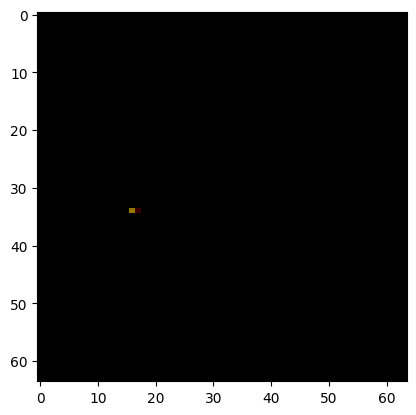

In [174]:
# Load up a cheese/no-cheese maze pair 
from experiments.patch_utils import *
from PIL import Image

seed = 0
venv = get_cheese_venv_pair(seed=seed)
obs = venv.reset()
obs = np.array(obs, dtype=np.float32)

# Show the diff of the RGB renders
print("The difference between the two images is:")
plt.imshow(rearrange(obs[0]-obs[1], 'c h w -> h w c'))

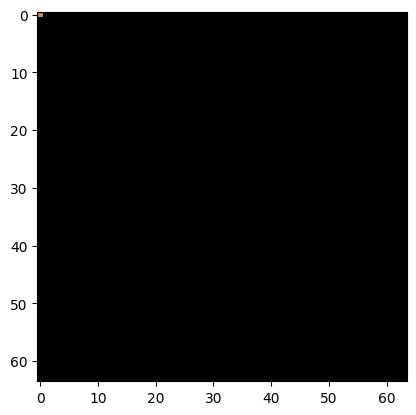

In [204]:
# CHEESE_PX = obs[0][(obs[0]-obs[1]) != 0]
# print(CHEESE_PX)

def locate_cheese(obs: np.ndarray):
    """ Return the location of the cheese in the given observation. Assumes that the first channel is nonzero iff there's cheese. """
    assert obs.shape == (3,64,64), f"Obs must be of shape (3,64,64), not {obs.shape}"
    cheese_location = np.where(obs[0] != 0)
    return list(zip(cheese_location[0], cheese_location[1]))

locate_cheese(obs[0]-obs[1])

def move_cheese(obs: np.ndarray, locations: List[Tuple[int,int]]):
    """ Return a new observation with the cheese moved to the given location. Assumes that the first channel is nonzero iff there's cheese. """
    assert obs.shape == (3,64,64), f"Obs must be of shape (3,64,64), not {obs.shape}"
    assert all(len(loc) == 2 for loc in locations), 'Locations must be tuples of length 2'
    assert all(all(0 <= x < 64 for x in loc) for loc in locations), 'Locations must be in [0, 64)'

    # Now move the cheese to the new location
    new_obs = np.zeros_like(obs)
    for loc in locations:
        new_obs[:, loc[0], loc[1]] = obs[:, loc[0], loc[1]]
    return new_obs
    
plt.imshow(rearrange(move_cheese(obs[0], [(0,0)]), 'c h w -> h w c'))

In [175]:
# Visualize the activations at each layer, given this observation difference
channel_slider = IntSlider(min=0, max=127, step=1, value=0)
fig = go.FigureWidget()
display(fig)

@interact
def plot_activations_interactive(label=Dropdown(options=labels), channel=channel_slider, x=IntSlider(min=0, max=62, step=1, value=32), y=IntSlider(min=0, max=63, step=1, value=32)):
    # Set max channel to be the max channel at this layer
    channel_slider.max = hook.get_value_by_label(label).shape[1] - 1 # TODO fix for fc_out
    # Ensure that the figure only displays once in the output
    plot_activation_diffs(label=label, channel=channel, obs=obs, fig=fig)

FigureWidget({
    'data': [], 'layout': {'template': '...'}
})

interactive(children=(Dropdown(description='label', options=('embedder.block1.conv_in0', 'embedder.block1.conv…